In [1]:
import numpy as np
import cv2

In [2]:
import matplotlib.pyplot as plt

In [3]:
def show_img(img):
    plt.imshow(img)
    plt.show()
    
def  resize_images(images, f=3):
    big_images = []
    for img in images:
        big_images.append(cv2.resize(img, None, fx=f, fy=f))
    return big_images

In [4]:
plt.rcParams["figure.figsize"]=10,10

#  Some useful functions

In [14]:
def get_dist(obj1, obj2):
    return math.sqrt((obj1[0]-obj2[0])**2 + (obj1[1]-obj2[1])**2)

In [20]:
def get_dist_nearest_obj(s):
    nobjs = len(s)/4
    ego = s[0:4]
    
    dist_nearest_obj = math.inf
    num_nearest_obj = -1
    
    idx = 4
    for n in range(nobjs):
        obj = s[idx:idx+4]
        dist = get_dist(ego, obj)
        
        if dist < dist_nearest_obj:
            dist_nearest_obj = dist
            num_nearest_obj = n
        end
        idx += 4
    end
    
    return dist_nearest_obj

In [21]:
def get_dist_to_goal(s, goal):
    return get_dist(s[0:4], goal)

# Time To Collision

In [28]:
def get_TTC(ego, obj, radius):
    x1, y1, vx1, vy1 = ego[0], ego[1], ego[2], ego[3]
    x2, y2, vx2, vy2 = obj[0], obj[1], obj[2], obj[3]

    a = (vx1 - vx2) **2 + (vy1 - vy2) **2
    b = 2 * ((x1 - x2) * (vx1 - vx2) + (y1 - y2) * (vy1 - vy2))
    c = (x1 - x2) **2 + (y1 - y2) **2 - radius **2

    if a == 0 and b == 0:
        if c == 0:
            return 0
        else:
            return np.inf

    if a == 0 and b != 0:
        t = -c / b
        if t < 0:
            return np.inf
        else:
            return t

    delta = b **2 - 4 * a * c
    if delta < 0:
        return np.inf

    t1 = (-b - np.sqrt(delta)) / (2 * a)
    t2 = (-b + np.sqrt(delta)) / (2 * a)
    if t1 < 0:
        t1 = np.inf

    if t2 < 0:
        t2 = np.inf

    return min(t1, t2)

In [27]:
def get_smallest_TTC(state_vector):
    radius = 15.0
    ego = state_vector[0:4]

    smallest_TTC = np.inf
    smallest_TTC_obj = -1

    idx = 4
    for id in np.arange(p['n_obj']):
        obj = state_vector[idx:idx+4]
        TTC = get_TTC(ego, obj, radius)

        if TTC < smallest_TTC:
            smallest_TTC = TTC
            smallest_TTC_obj = id
        idx += 4

    return smallest_TTC, smallest_TTC_obj

In [29]:
# just checking
obj1 = np.array([0.0, 100, 20, 0])
obj2 = np.array([100, 0.0, 0, 20])
print("dist: ", get_dist(obj1, obj2))
print("TTC: ", get_TTC(obj1, obj2, 15.0))


dist:  141.4213562373095
TTC:  4.4696699141100895


# Openai gym Anti Collision Test Env

In [5]:
##################################################################
# Anti Collision Tests env compatible with gym openai interface
##################################################################

# API eg https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py


import gym
from gym import spaces, logger
from gym.utils import seeding

import math
import numpy as np
import cv2


def draw_arrow(image, p, q, color, arrow_magnitude=5, thickness=1, line_type=4, shift=0):
    # adapted from http://mlikihazar.blogspot.com.au/2013/02/draw-arrow-opencv.html
    # draw arrow tail
    cv2.line(image, p, q, color, thickness, line_type, shift)
    # calc angle of the arrow
    angle = np.arctan2(p[1]-q[1], p[0]-q[0])
    # starting point of first line of arrow head
    p = (int(q[0] + arrow_magnitude * np.cos(angle + np.pi/4)),
    int(q[1] + arrow_magnitude * np.sin(angle + np.pi/4)))
    # draw first half of arrow head
    cv2.line(image, p, q, color, thickness, line_type, shift)
    # starting point of second line of arrow head
    p = (int(q[0] + arrow_magnitude * np.cos(angle - np.pi/4)),
    int(q[1] + arrow_magnitude * np.sin(angle - np.pi/4)))
    # draw second half of arrow head
    cv2.line(image, p, q, color, thickness, line_type, shift)

# Transition with Constant Acceleration model
def transition_ca(s, a, dt=0.2):
    Ts = np.matrix([[1.0, 0.0, dt,  0.0], 
                [0.0, 1.0, 0.0, dt],
                [0.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0, 1.0]])
    Ta = np.matrix([[0.5*dt**2, 0.0],
                [0.0,      0.5*dt**2],
                [dt,       0.0],
                [0.0,      dt]])
    return np.dot(Ts, s) + np.dot(Ta, a)
    
    

class ActEnv(gym.Env):
    def __init__(self, nobjs):    
        self.nobjs = nobjs
        self.max_accel = 2
        
        self.action_space = spaces.Box(low=-self.max_accel, high=self.max_accel, shape=(1,))
        # 1+nobjs: x,y,vx,vy with x,y in [0,200] and vx,vy in [0,40]
        self.observation_space = spaces.Box(low=0.0, high=200.0, shape=((1+nobjs)*4,))
        
        self.seed()
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
        
    def reset(self):
        # x, y, vx, vy
        self.start = np.array([100.0,   0.0,  0.0,  20.0], dtype=int)
        self.goal  = np.array([100.0, 200.0, 0.0, 0.0], dtype=int)
        # states init
        state = ego = self.start
        for n in range(int(self.nobjs/2)):
            x = self.np_random.randint(low=0, high=50)
            y = self.np_random.randint(low=25, high=190)
            vx = self.np_random.randint(low=10, high=25)
            vy = self.np_random.randint(low=0, high=5)
            obj = np.array([x, y, vx, vy])
            state = np.append(state, obj)
        
        for n in range(int(self.nobjs/2)):
            x = self.np_random.randint(low=150, high=200)
            y = self.np_random.randint(low=25, high=190)
            vx = - self.np_random.randint(low=10, high=25)
            vy = - self.np_random.randint(low=0, high=5)
            obj = np.array([x, y, vx, vy])
            state = np.append(state, obj)     
        print(state)  
        self.s = state
        
        return self.s
        
    def render(self):
        img = np.zeros([250, 250, 3],dtype=np.uint8)
        img.fill(255) # or img[:] = 255
        cv2.putText(img, 'Anti Collision Tests', (50, 240), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))
        
        x = self.s[0]; y = self.s[1]; vx = self.s[2]; vy = self.s[3]; v = int(math.sqrt(vx**2 + vy**2)*3.6)
        color = (0, 0, 255) # blue
        cv2.circle(img, (x, y), 2, color, -1)
        draw_arrow(img, (int(x), int(y)), (int(x+vx), int(y+vy)), color)        
        cv2.putText(img, str(v) + ' kmh', (x+vx+5, y+vy), cv2.FONT_HERSHEY_SIMPLEX, 0.25, color)
        
        color = (0, 255, 0) # green
        for i in range(self.nobjs):
            idx = (i+1)*4
            x = self.s[idx]; y = self.s[idx+1]; vx = self.s[idx+2]; vy = self.s[idx+3]; v = int(math.sqrt(vx**2 + vy**2)*3.6)
            cv2.circle(img, (x, y), 2, color, -1)
            draw_arrow(img, (int(x), int(y)), (int(x+vx), int(y+vy)), color)        
            cv2.putText(img, str(v) + ' kmh', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.25, (0,0,0))
        
        #img = cv2.resize(img, None, fx=20, fy=20)
        #img = cv2.resize(img,(2500, 2500))
        return img
        
    #state, reward, done, info = env.step(action)
    def step(self, action):
        reward = -1
        done = False
        
        s = self.s[0:4]
        a = np.array([0.0, action])
        self.s[0:4] = transition_ca(s, a)
        
        idx = 4
        for n in range(self.nobjs):
            s = self.s[idx:idx+4]
            a = np.array([0.0, 0.0]) # TODO CALL Driving Model
            self.s[idx:idx+4] = transition_ca(s, a)
            idx += 4
            
        return self.s, reward, done, {}
    
    def close(self):
        return

In [6]:
env = ActEnv(10)

[100   0   0  20  14  88  17   2  42  81  11   4   8 165  22   4   0 152
  10   0  10 132  18   2 185 110 -17   0 160 129 -17   0 157  32 -19  -4
 181 124 -20   0 182  28 -18  -4]


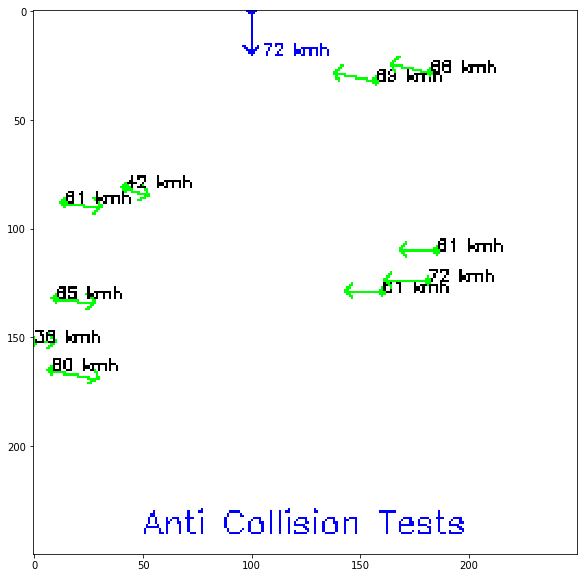

In [7]:
img = env.render()

plt.imshow(img)
plt.show()

In [8]:
pipo = np.arange(20)

In [9]:
max_steps = 20
images = []


for i in range(max_steps):
    env.step(0)
    img = env.render()
    images.append(img)

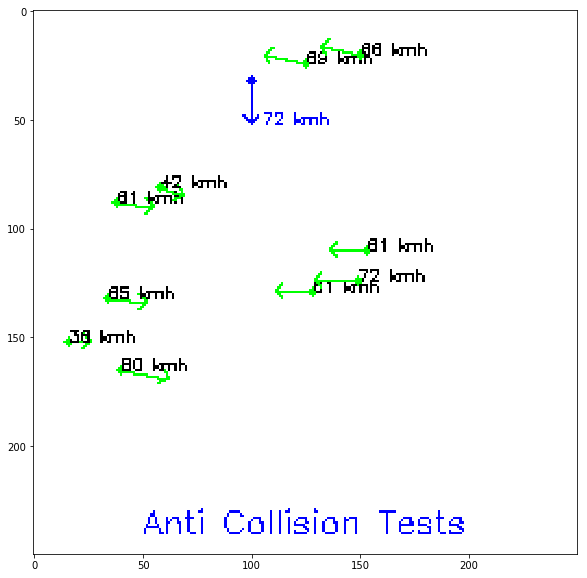

In [10]:
show_img(images[7])

# Visualization

In [11]:
import imageio
from IPython.core.display import HTML

In [12]:
imageio.mimsave('img/visu.gif', images, duration=0.2)
HTML("""<img src="img/visu.gif"/>""")

In [13]:
big_images = resize_images(images, f=2)
imageio.mimsave('img/visu2.gif', big_images, duration=0.2)
HTML("""<img src="img/visu2.gif"/>""")